In [1]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

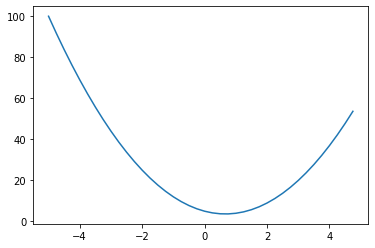

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Calculate derivative
h = 0.0001
x = -3.0

(f(x + h) - f(x))/h

-21.999700000066014

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2  = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [8]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return self * other**-1
        

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __repr__(self):
        return f"Value(data={self.data})"
    


In [9]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label='d'
e = d + c; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

Value(data=-8.0)

In [11]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [12]:
#Visualize expression graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [13]:
# Manually enter grad values.
L.grad = 1.0
e.grad = -2.0
f.grad = 4.0

d.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

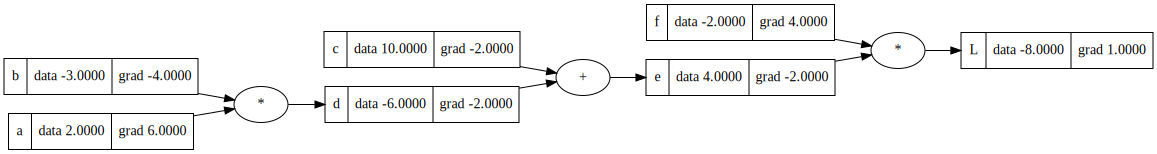

In [14]:
draw_dot(L)

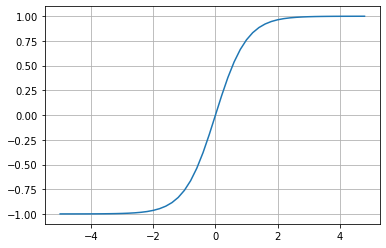

In [15]:
# Activation function - Tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Biological Neuron<br>
<img src="https://cs231n.github.io/assets/nn1/neuron.png" width="600"><br>
<br>
Mathematical Model<br>
<img src = "https://cs231n.github.io/assets/nn1/neuron_model.jpeg" width="600">

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# o = n.tanh(); o.label='o'
e = (2*n).exp()
o = (e-1) / (e+1)

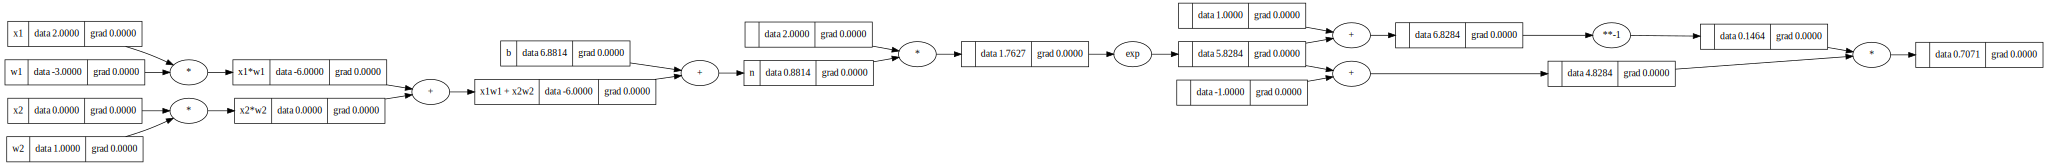

In [17]:
draw_dot(o)

In [18]:
# #Manual Backpropogation through neuron
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 1 - o.data**2

# # Plus operation - local distributer of derivative
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # Mult derviative - y of x & z
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [19]:
# o.grad = 1.0
# o._backward()

# n._backward()
# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

In [20]:
# #Topological sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# o.grad = 1.0
# for node in reversed(topo):
#     node._backward()

In [21]:
# #Accumlative gradient
# a = Value(3.0, label='a')
# b = a + a; b.label='b'
# b.backward()
# draw_dot(b)

In [22]:
o.backward()

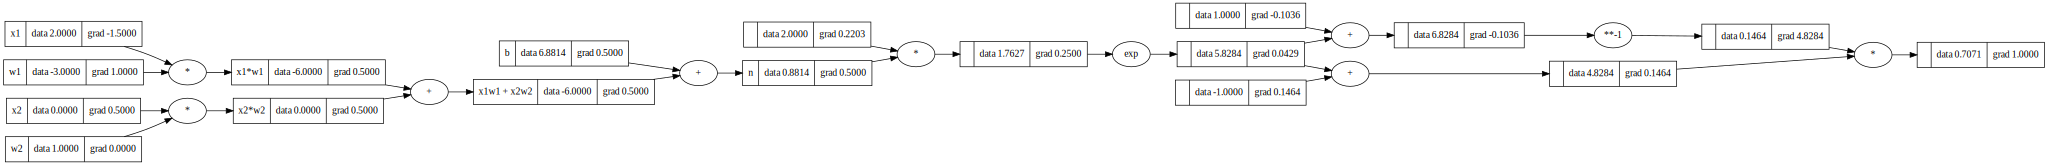

In [23]:
draw_dot(o)

In [24]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
          

In [25]:
x = [2.0, 3.0, -1.0]

# # Single neuron
# n = Neuron(2)
# n(x)

# # Layer of neurons
# n = Layer(2, 3)
# n(x)

# Multi-Layer Perceptron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6006552115787069)

In [26]:
len(n.parameters())

41

In [27]:
n.parameters()

[Value(data=-0.7517074891515345),
 Value(data=-0.8115080117570468),
 Value(data=0.12601191819148738),
 Value(data=-0.09020481488191345),
 Value(data=-0.00978921915614639),
 Value(data=-0.4632440708994068),
 Value(data=-0.7264081690037898),
 Value(data=-0.9508049048365168),
 Value(data=-0.43491242972932276),
 Value(data=0.27849382428734515),
 Value(data=-0.43296462419977),
 Value(data=-0.4282298512486009),
 Value(data=-0.8563259770049274),
 Value(data=0.8167183438739536),
 Value(data=-0.7050958554122697),
 Value(data=-0.8944698469538854),
 Value(data=0.3708963374928085),
 Value(data=0.9639394107116257),
 Value(data=0.010042817011283622),
 Value(data=0.0753259453298667),
 Value(data=0.755479620356988),
 Value(data=0.5867052743245884),
 Value(data=-0.8868622294424904),
 Value(data=0.3740335243784336),
 Value(data=0.29954795830276093),
 Value(data=-0.27122654120185796),
 Value(data=-0.41158097075768274),
 Value(data=-0.1582639394883072),
 Value(data=0.27265980969041004),
 Value(data=-0.748

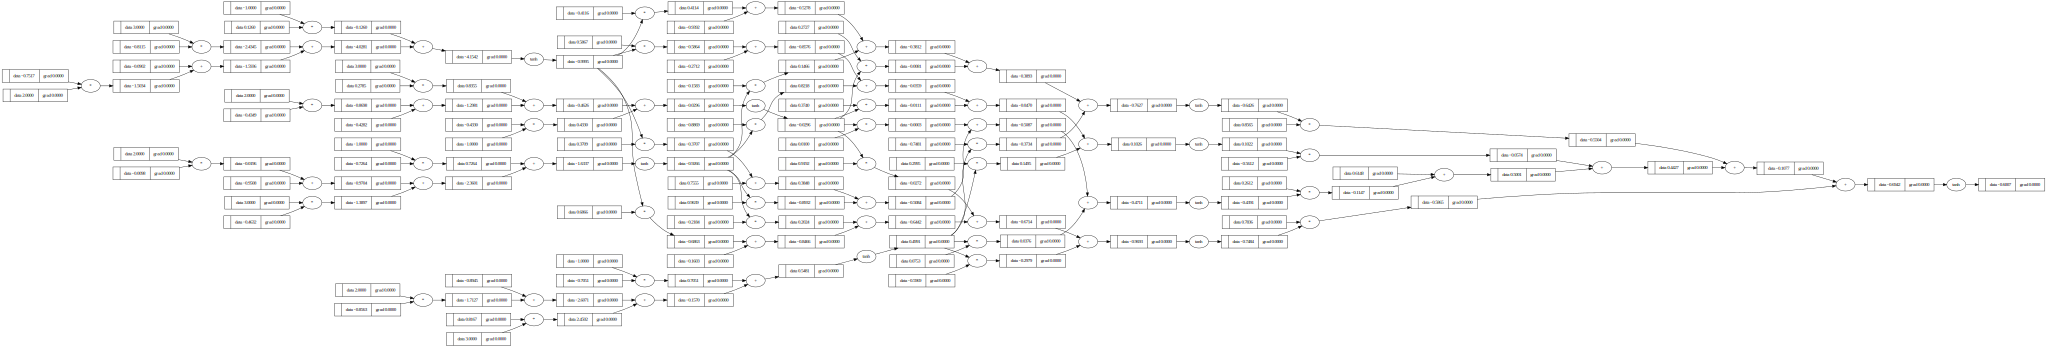

In [28]:
draw_dot(n(x))

In [29]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]

ys = [1.0, -1.0, -1.0, 1.0]

In [30]:
# ypred = [n(x) for x in xs]
# ypred

In [31]:
# #mean-squared error
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [32]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data

In [33]:
for k in range(100):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))   #mean-squared error

    #backward pass
    for p in n.parameters(): # zero_grad
        p.grad = 0.0
    loss.backward()

    # update - stocastic gradient descent
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 6.842815664799255
1 0.7424518847519471
2 0.3807506060177192
3 0.15063843151780443
4 0.09680497011978678
5 0.07565687571532675
6 0.0615707120178899
7 0.05158455780858428
8 0.04417626674307348
9 0.03848684884262845
10 0.03399650234858158
11 0.030373166287115783
12 0.027395320935483147
13 0.02490985501685989
14 0.02280776263048285
15 0.021009467596034864
16 0.019455612942930883
17 0.018101086840955776
18 0.01691103591525625
19 0.01585813791236159
20 0.0149206946427196
21 0.01408127234454524
22 0.013325715353792048
23 0.012642419317438798
24 0.01202178802825323
25 0.011455822235109998
26 0.01093780468218917
27 0.010462056240973973
28 0.010023745202571257
29 0.009618736765884112
30 0.009243473233246187
31 0.008894877889962783
32 0.008570277313701365
33 0.008267338144643492
34 0.007984015290448248
35 0.007718509239262667
36 0.007469230677211175
37 0.00723477100174768
38 0.007013877622866453
39 0.006805433174753226
40 0.006608437938637748
41 0.0064219949162436585
42 0.006245297101814862
43 

In [34]:
ypred

[Value(data=0.9852107754923236),
 Value(data=-0.9745308841910901),
 Value(data=-0.9698272160414848),
 Value(data=0.9759557220513783)]

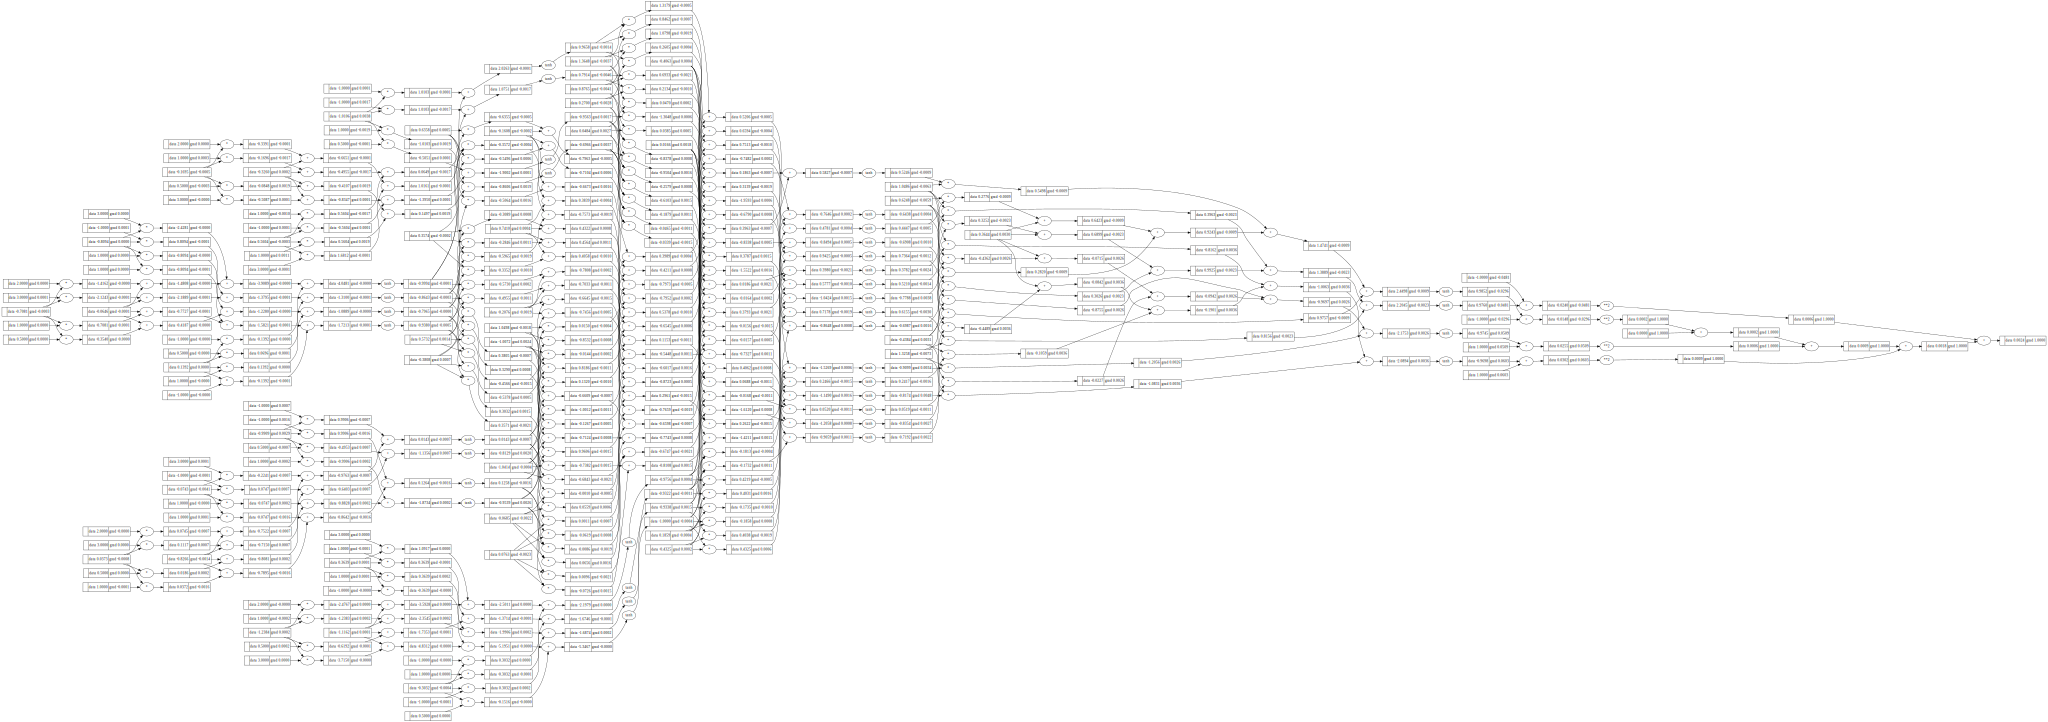

In [35]:
draw_dot(loss)